Github repo for the original paper: [https://github.com/MaartenGr/BERTopic_evaluation/tree/main](https://github.com/MaartenGr/BERTopic_evaluation/tree/main) 

In [2]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
from typing import Mapping, List

In [3]:

class Results:
    def __init__(self, main_folder: str, combine_models: bool = False) -> None:
        self.main_folder = main_folder
        self.combine_models = combine_models

        self.basic_results = {}
        self.dtm_results = {}

        self._load_results()

    def get_data(self, name, dtm: bool = False, aggregated: bool = False):
        if dtm:
            if aggregated:
                numeric_df = self.dtm_results[name][["npmi", "diversity", "Model"]]
                return numeric_df.groupby("Model").mean()
            else:
                return self.dtm_results[name]
        else:
            if aggregated:
                numeric_df = self.basic_results[name][["npmi", "diversity", "Model"]]
                return numeric_df.groupby("Model").mean()
            else:
                return self.basic_results[name]

    def get_keys(self):
        return {
            "basic": list(self.basic_results.keys()),
            "dtm": list(self.dtm_results.keys()),
        }

    def visualize_table(self, dtm: bool = False, models: List[str] = None):
        if dtm:
            results = self.dtm_results["all"].copy()
        else:
            results = self.basic_results["all"].copy()
        
        datasets = set([column for column, _ in results.columns if column])

        if models:
            results = results.loc[results[""]["Model"].isin(models), :]
        
        return (
            results
        )

    def visualize_table_tq(self, dtm: bool = False):
        if dtm:
            to_plot = self.dtm_results["all"].copy()
        else:
            to_plot = self.basic_results["all"].copy()
        

        datasets = list(set([column for column, _ in to_plot.columns if column]))
        models = to_plot[""]["Model"].values
        averaged_results = pd.DataFrame({"Model": models})

        for dataset in datasets:
            averaged_results[dataset] = (
                to_plot[dataset]["npmi"] * to_plot[dataset]["diversity"]
            )
            averaged_results[dataset] = averaged_results[dataset].astype(float).round(3)

        return (
            averaged_results.style.apply(highlight_max)
            .format(
                formatter={
                    (dataset): "{:.3f}"
                    for dataset in datasets
                    for method in ["npmi", "diversity"]
                }
            )
            .set_properties(**{"width": "10em", "text-align": "center"})
            .set_table_styles([dict(selector="th", props=[("text-align", "center")])])
        )

    def _load_results(self):
        folders = os.listdir(self.main_folder)

        if "Basic" in folders:
            for folder in os.listdir(self.main_folder + "/Basic"):
                self._results_per_folder(f"{self.main_folder}Basic/{folder}")
 
            self._load_all_results()
        

        if "Dynamic Topic Modeling" in folders:
            for folder in os.listdir(self.main_folder + "Dynamic Topic Modeling"):
                self._load_dtm_results(
                    f"{self.main_folder}Dynamic Topic Modeling/{folder}"
                )
            self._load_all_results(dtm=True)

        if "Computation" in folders:
            self._load_computation_results()

    def _load_all_results(self, dtm=False):
        # Load data
        if dtm:
            # MODIFIED
            data = {}
            for dataset, dataframe in self.dtm_results.items():
                numeric_df = dataframe[["npmi", "diversity", "Model"]]

                data[dataset] = (
                    numeric_df.groupby("Model")
                    .mean()
                    .loc[:, ["npmi", "diversity"]]
                    .reset_index()
                )
        else:
            # MODIFIED
            data = {}
            for dataset, dataframe in self.basic_results.items():
                numeric_df = dataframe[["npmi", "diversity", "Model"]]

                data[dataset] = (
                    numeric_df.groupby("Model")
                    .mean()
                    .loc[:, ["npmi", "diversity"]]
                    .reset_index()
                )

        print(list(data.keys()))
        # Sort by model before concatenating
        # MODIFIED from -2 to 0
        order = data[list(data.keys())[0]].sort_values("npmi")["Model"].tolist()
        models = pd.DataFrame({"Model": order})

        for dataset in data.keys():
            data[dataset] = (
                data[dataset]
                .set_index("Model")
                .loc[order]
                .reset_index()
                .drop("Model", axis=1)
            )


        # MultiIndex
        models.columns = pd.MultiIndex.from_product([[""], models.columns])

        for dataset in data.keys():
            data[dataset].columns = pd.MultiIndex.from_product(
                [[dataset], data[dataset].columns]
            )

        results = (
            pd.concat([models] + [data[dataset] for dataset in data.keys()], axis=1)
            .round(3)
            .astype(object)
        )

        if dtm:
            self.dtm_results["all"] = results
        else:
            self.basic_results["all"] = results

    def _results_per_folder(self, folder) -> pd.DataFrame:
        """Load the results for topic model evaluation

        Args:
            main_folder: The main folder from which to extract
                        the results. Make sure that they are
                        saved as .json and follow the evaluation
                        procedure.

        Returns:
            results: The results in a dataframe format where each
                    evaluation point is saved per row
        """

        # Extract all results from the folder
        data_path = [
            data_path
            for data_path in os.listdir(folder)
            if ".json" in data_path and "metadata" not in data_path
        ]

        # Initialize empty df for results
        columns = [
            "Dataset",
            "Model",
            "nr_topics",
            "npmi",
            "diversity",
            "params",
            "Dataset_Size",
            "ComputationTime",
        ]
        results = pd.DataFrame(columns=columns)

        # Extract results from each file
        for index, path in enumerate(data_path):

            # Load raw results
            with open(f"{folder}/{path}", "r") as f:
                data = json.load(f)

            # Write all results to `results`
            for row in data:

                # General info
                dataset = row["Dataset"]
                if self.combine_models:
                    model = row["Model"]
                else:
                    model = row["Model"] + f"_{index}"

                params = row["Params"]
                dataset_size = row["Dataset Size"]
                computation_time = row["Computation Time"]

                # Extract scores
                npmi = row["Scores"]["npmi"]
                diversity = row["Scores"]["diversity"]

                # Get the number of topics depending on how they are
                # defined in the model
                if row["Params"].get("nr_topics"):
                    nr_topics = row["Params"]["nr_topics"]
                elif row["Params"].get("num_topics"):
                    nr_topics = row["Params"]["num_topics"]
                elif row["Params"].get("n_components"):
                    nr_topics = row["Params"]["n_components"]
                else:
                    nr_topics = None

                results.loc[len(results), :] = [
                    dataset,
                    model,
                    nr_topics,
                    npmi,
                    diversity,
                    params,
                    dataset_size,
                    computation_time,
                ]

        # Making sure they have the correct type
        for column in ["npmi", "diversity"]:
            results[column] = results[column].astype(float)

        self.basic_results[dataset] = results

    def _load_dtm_results(self, folder):
        datasets = os.listdir(folder)

        # Initialize empty df for results
        columns = [
            "Dataset",
            "Model",
            "time_slice",
            "nr_topics",
            "npmi",
            "diversity",
            "params",
            "Dataset_Size",
            "ComputationTime",
        ]
        results = pd.DataFrame(columns=columns)

        for data_name in datasets:
            with open(f"{folder}/{data_name}", "r") as f:
                data = json.load(f)

            model = data_name.split(".json")[0][:-1]

            for row in data:
                for time_slice, score in row["Scores"].items():

                    # General info
                    dataset = row["Dataset"]
                    params = row["Params"]
                    dataset_size = row["Dataset Size"]
                    computation_time = row["Computation Time"]

                    # Extract scores
                    npmi = score["npmi"]
                    diversity = score["diversity"]

                    # Get the number of topics depending on how they are
                    # defined in the model
                    if row["Params"].get("nr_topics"):
                        nr_topics = row["Params"]["nr_topics"]
                    elif row["Params"].get("num_topics"):
                        nr_topics = row["Params"]["num_topics"]
                    elif row["Params"].get("n_components"):
                        nr_topics = row["Params"]["n_components"]
                    else:
                        nr_topics = None

                    results.loc[len(results), :] = [
                        dataset,
                        model,
                        time_slice,
                        nr_topics,
                        npmi,
                        diversity,
                        params,
                        dataset_size,
                        computation_time,
                    ]

        for column in ["npmi", "diversity"]:
            results[column] = results[column].astype(float)

        self.dtm_results[dataset] = results

    def _load_computation_results(self):
        path = "./results/Computation/"
        files = os.listdir(path)

        computation = pd.read_csv(path + files[0])
        computation["model"] = files[0]

        for file in files[1:]:
            df_to_add = pd.read_csv(path + file)
            df_to_add["model"] = file
            computation = computation.append(df_to_add)

        self.computation = computation

    def plot_results(
        self,
        dataset: pd.DataFrame = None,
        title: str = None,
        x: str = "nr_topics",
        y: str = "npmi",
        xlabel: str = None,
        ylabel: str = None,
        figsize: tuple = (10, 5),
        confidence_interval: bool = False,
    ):

        results = self.basic_results[dataset].copy()

        fig, ax = plt.subplots(figsize=figsize)

        for model in results.Model.unique():
            selection = results.loc[results.Model == model, :]

            numeric_df = selection[["npmi", "diversity", "nr_topics"]]

            if confidence_interval:
                # Define variables to plot
                y_mean = numeric_df.groupby("nr_topics").mean()[y]
                x_vals = y_mean.index

                # Compute upper and lower bounds using chosen uncertainty measure: here
                # it is a fraction of the standard deviation of measurements at each
                # time point based on the unbiased sample variance
                y_std = numeric_df.groupby("nr_topics").std()[y]
                error = 0.5 * y_std
                lower = y_mean - error
                upper = y_mean + error

                ax.plot(x_vals, y_mean, label=model)
                ax.fill_between(x_vals, lower, upper, alpha=0.2)
            else:
                ax.plot(selection[x], selection[y], label=model)

        if xlabel:
            ax.set_xlabel(xlabel)
        else:
            ax.set_xlabel(x)

        if ylabel:
            ax.set_ylabel(ylabel)
        else:
            ax.set_ylabel(y)

        plt.grid(axis="x", color=".7", which="major", linestyle="dashed")
        plt.grid(axis="y", color=".7", which="major", linestyle="dashed")

        ax.tick_params(axis="y", direction="in", length=8, which="major")
        ax.tick_params(axis="y", direction="in", length=4, which="minor")
        ax.tick_params(axis="y", direction="in", length=4, which="minor", right=True)

        ax.tick_params(axis="x", direction="in", length=8, which="major")
        ax.tick_params(axis="x", direction="in", length=4, which="minor")
        ax.tick_params(axis="x", direction="in", length=4, which="minor", top=True)

        ax.tick_params(right=True, top=True)

        ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
        ax.xaxis.set_minor_locator(tck.AutoMinorLocator())

        plt.xticks(np.arange(min(results[x]), max(results[x]) + 1, 10))

        plt.title(title)
        plt.legend()

        return fig

    def plot_computation(
        self,
        labels: Mapping = None,
        title: str = None,
        xlabel: str = "Vocabulary size",
        ylabel: str = "Wall time (s)",
        figsize: tuple = (10, 5),
        with_ctm: bool = True,
    ):
        fig, ax = plt.subplots(figsize=figsize)
        models = list(self.computation.model.unique())
        linestyles = {"BERTopic": "solid", "Classic": "solid", "Top2Vec": "solid"}

        if not with_ctm:
            models.remove("ctm.csv")

        for model in models:

            selection = self.computation.loc[self.computation.model == model, :]

            if "bertopic" in model:
                linestyle = linestyles["BERTopic"]
            elif "top2vec" in model:
                linestyle = linestyles["Top2Vec"]
            else:
                linestyle = linestyles["Classic"]

            if labels:
                ax.plot(
                    selection.vocab_size,
                    selection.time,
                    label=labels[model],
                    linestyle=linestyle,
                )
            else:
                ax.plot(
                    selection.vocab_size,
                    selection.time,
                    label=model,
                    linestyle=linestyle,
                )

        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)

        plt.grid(axis="x", color=".7", which="major", linestyle="dashed")
        plt.grid(axis="y", color=".7", which="major", linestyle="dashed")

        ax.tick_params(axis="y", direction="in", length=8, which="major")
        ax.tick_params(axis="y", direction="in", length=4, which="minor")
        ax.tick_params(axis="y", direction="in", length=4, which="minor", right=True)

        ax.tick_params(axis="x", direction="in", length=8, which="major")
        ax.tick_params(axis="x", direction="in", length=4, which="minor")
        ax.tick_params(axis="x", direction="in", length=4, which="minor", top=True)

        ax.tick_params(right=True, top=True)

        ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
        ax.xaxis.set_minor_locator(tck.AutoMinorLocator())

        plt.xticks(np.arange(2500, max(self.computation.vocab_size), 2500))

        plt.title(title)
        plt.legend()

        return fig


def highlight_max(data):
        return data

In [4]:
results = Results("./results/", combine_models=True)
results.get_keys()

['20NewsGroup', 'BBC_News', 'trump']
['trump_dtm']


{'basic': ['20NewsGroup', 'BBC_News', 'trump', 'all'],
 'dtm': ['trump_dtm', 'all']}

In [6]:
results.get_data("20NewsGroup", aggregated=True)

,npmi,diversity
Model,,
BERTopic,0.163573,0.847011
BERTopic_USE,0.153303,0.851433
BERTopic_mini,0.158373,0.828722
LDA,0.058070,0.748867
NMF,0.088495,0.660933


In [7]:
results.get_data("BBC_News", aggregated=True)

,npmi,diversity
Model,,
BERTopic,0.170681,0.844679
BERTopic_USE,0.165463,0.791705
BERTopic_mini,0.156164,0.854801
LDA,0.014037,0.577422
NMF,0.012052,0.549000


## Table 1

* For LDA, NMF, and BERTopic-MPNET, our results are almost the same as the orginal paper. The CTM for Trump data is also close to the original.
* The BERTopic-MPNET outperform LDA and NMF. Though CTM has higher diversity score than BERTopic-MPNET, it suffered the same issue of significantly longer training time as in the paper.

Table 1 Results from the original paper

![Table 1](imgs/table1.png)

In [10]:
models = ['LDA', 'NMF', 'BERTopic']
results.visualize_table(models=models)

20NewsGroup           BBC_News            trump          
      Model        npmi diversity     npmi diversity   npmi diversity
0       LDA       0.058     0.749    0.014     0.577 -0.011     0.503
1       NMF       0.088     0.661    0.012     0.549  0.009     0.379
4  BERTopic       0.164     0.847    0.171     0.845  0.067     0.664

In [5]:
results.get_data("trump", aggregated=True)

,npmi,diversity
Model,,
BERTopic,0.067421,0.664133
BERTopic_USE,0.063097,0.659656
BERTopic_mini,0.059995,0.671011
CTM_CUSTOM,0.016275,0.859367
LDA,-0.010568,0.502844
NMF,0.009188,0.379400


## Table 2

* Again, our results using the three embeddings are similar to the paper.

Table 2 Results from the original paper

![Table 2](imgs/table2.png)

In [5]:
results.visualize_table(models=['BERTopic_USE', 'BERTopic_mini', 'BERTopic'])

20NewsGroup           BBC_News            trump          
           Model        npmi diversity     npmi diversity   npmi diversity
2   BERTopic_USE       0.153     0.851    0.165     0.792  0.063      0.66
3  BERTopic_mini       0.158     0.829    0.156     0.855   0.06     0.671
4       BERTopic       0.164     0.847    0.171     0.845  0.067     0.664

## Table 3

* Again, our results for the Trump dynamic topic modelling are similar to the paper.

Table 3 Results from the original paper

![Table 3](imgs/table3.png)

In [8]:
results.get_data("trump_dtm", dtm=True, aggregated=True)

,npmi,diversity
Model,,
DynamicBERTopic_trump_,0.078985,0.858752


In [85]:
results.visualize_table(dtm=True)

trump_dtm          
                    Model      npmi diversity
0  DynamicBERTopic_trump_     0.079     0.859

## Performance of models over the range of number of topics 10-50

* Again, similar to the paper [Link](https://github.com/MaartenGr/BERTopic_evaluation/blob/main/notebooks/Results.ipynb)

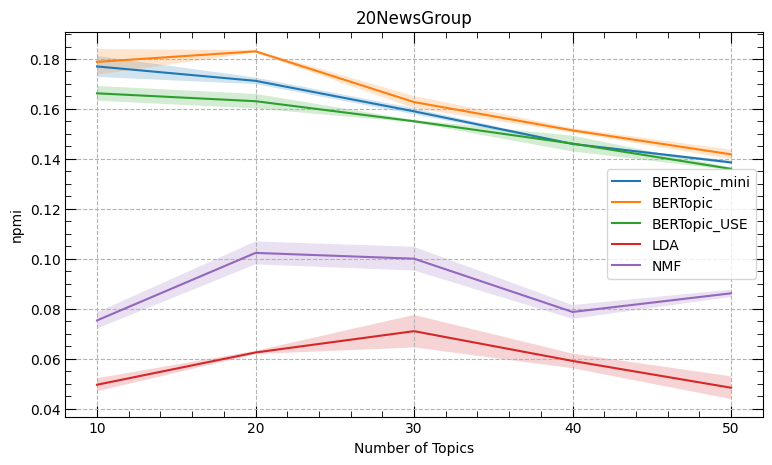

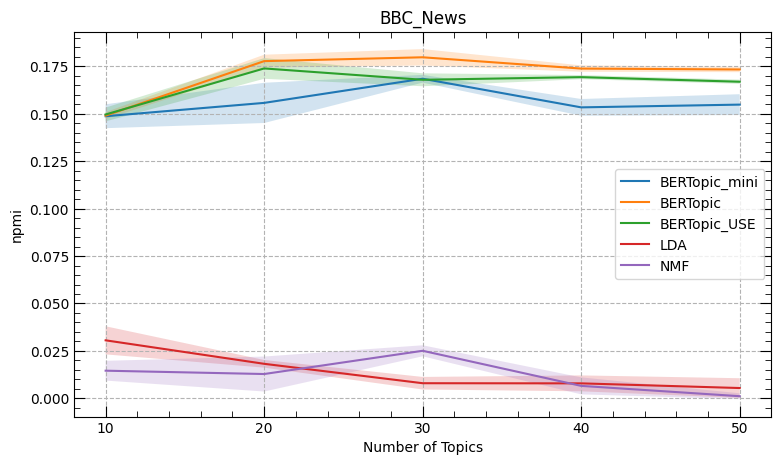

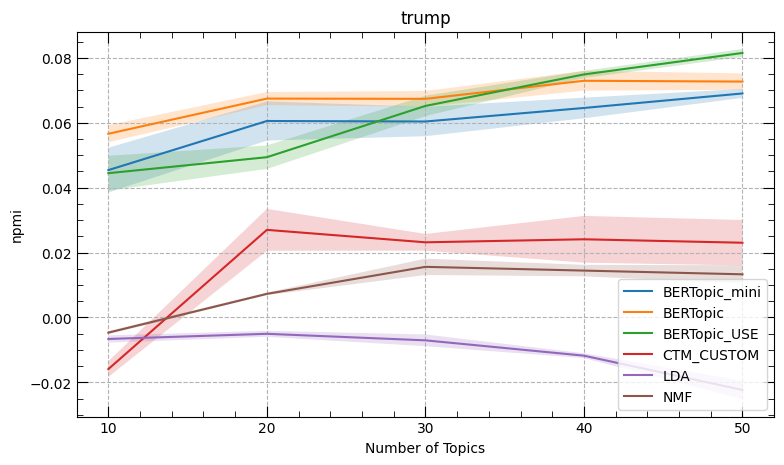

In [92]:
for dataset in results.get_keys()["basic"]:
    if dataset != "all":
        fig = results.plot_results(dataset, title=dataset, x="nr_topics", y="npmi", xlabel="Number of Topics",
                                    ylabel="npmi", figsize=(9, 5), confidence_interval=True)

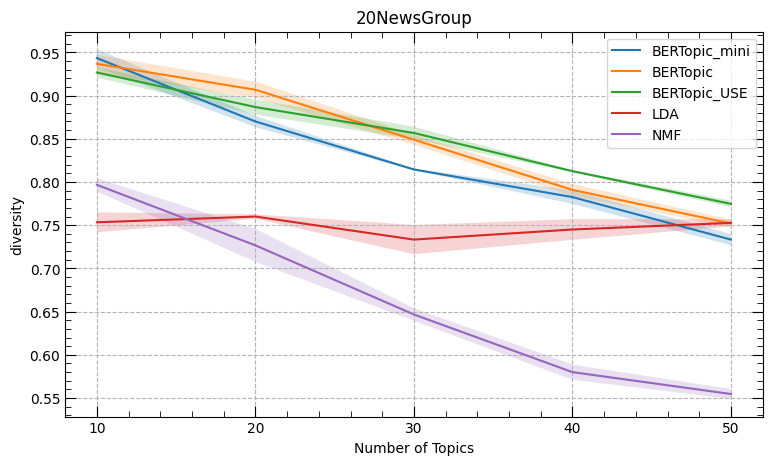

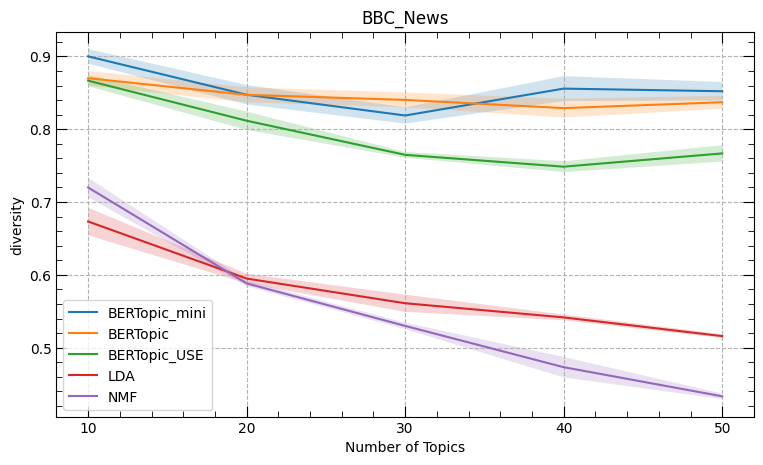

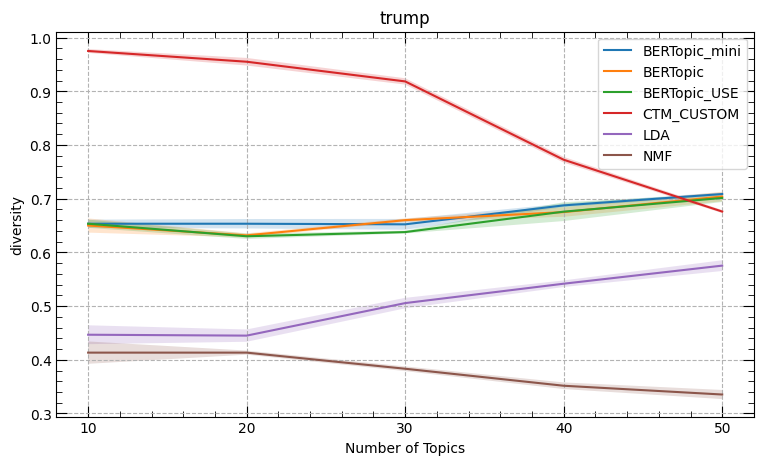

In [93]:
for dataset in results.get_keys()["basic"]:
    if dataset != "all":
        fig = results.plot_results(dataset, title=dataset, x="nr_topics", y="diversity", xlabel="Number of Topics",
                                    ylabel="diversity", figsize=(9, 5), confidence_interval=True)